# Predicting Tennis Tournament Levels from Player Stats

## Introduction
The ATP is a tennis organization that organizes and runs various tennis tournaments. Each tournament is categorized in the following way:
- G: Grand slams
- M: Master 1000s
- D: Davis cup
- F: tour finals + other ending events
- A: other events

We wish to determine if there is a connection between the tournament level and the statistics of the game and players. This leads us to the question: 

> Can we predict the level of a tennis tournament from game length and the players’ ages and heights?

The dataset contains the game results and player information for the Top 500 players from 2017-2019.  It contains stats from both the winner and loser of a match at a tournament level. It was compiled [here](https://github.com/JeffSackmann/tennis_atp) by Jeff Sackmann.

## Preliminary Exploration

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Load data (csv format) from URL, select columns we plan to use, drop rows with missing data.

tennis_data = read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn") %>%
    select(tourney_level, winner_ht, loser_ht, winner_age, loser_age, minutes) %>%
    na.omit() %>% 
    rename(match_length = minutes)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [3]:
# Split data into training and testing set

tennis_split <- initial_split(tennis_data, prop = .75, strata = tourney_level)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)

In [4]:
# Count the number of rows for each tournament level.
tennis_summary_num <- tennis_train %>%
    group_by(tourney_level) %>%
    summarize(n = n())

# Calculate the mean for all other columns.
#    Prepends 'mean.' to the front of all column names.
tennis_summary <- tennis_train %>% 
    group_by(tourney_level) %>%
    summarize_all(mean) %>% 
    rename_with(~ paste0("mean.", .), .cols = !tourney_level)

# Join summary tables (count + average)
summary_table <- tennis_summary_num %>% 
    inner_join(tennis_summary)

summary_table

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "tourney_level"



tourney_level,n,mean.winner_ht,mean.loser_ht,mean.winner_age,mean.loser_age,mean.match_length
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1104,186.2790,185.7663,29.66458,30.12695,99.5933
D,56,184.3393,184.6607,29.32551,29.68128,137.4286
F,15,191.5333,192.6000,28.54447,31.20256,103.6000
G,448,187.2634,186.3036,29.82923,29.79017,150.4353
M,526,187.1920,186.3460,29.55765,29.67469,100.8422


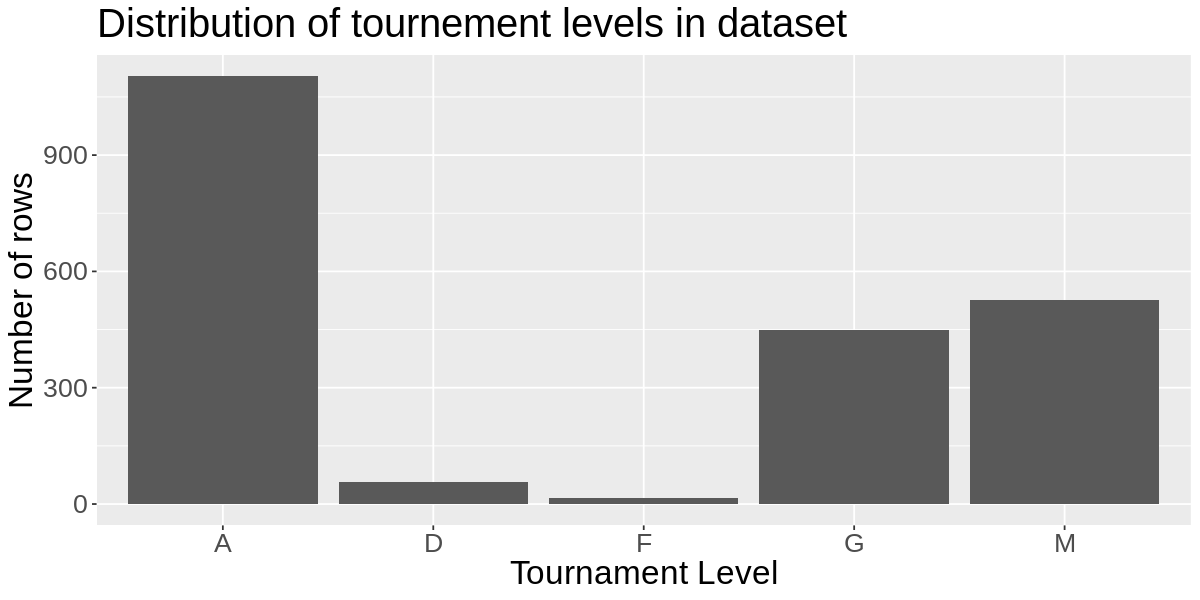

In [5]:
options(repr.plot.width = 10, repr.plot.height = 5)

# Plot the number of rows for each tournament level. 
#     Determines if we need to trim data to balance it or not,
#     which we obviously do.

tourney_level_dist <- ggplot(summary_table, aes(x = tourney_level, y = n)) +
    geom_bar(stat = 'identity') +
    theme(text = element_text(size = 20)) +
    labs(x = "Tournament Level",
             y = "Number of rows",
             colour = "Tournament level",
             title = "Distribution of tournement levels in dataset")

tourney_level_dist

In [6]:
# Convert the data from a prediction format into a format that can be easily plotted.
#    Pivots the data to add an extra column called 'player_type' which specifies if the player is a winner or loser.
#    This means that the data can be plotted on a facet_grid nicely without having to do any trickery.

plot_data <- tennis_train %>% 
    mutate(row = row_number()) %>%
    pivot_longer(winner_ht:loser_age, names_to = c("player_type", "category"), names_pattern = "([A-Za-z]+)_([A-Za-z]+)", values_to = "value") %>%
    mutate(category = as_factor(category)) %>% 
    mutate(player_type = as_factor(player_type)) %>% 
    pivot_wider(names_from = category, values_from = value) %>% 
    select(-row)

In [7]:
# Plot the match length vs the player height for both winner and loser and each tournament level. 

tennis_plot_height = plot_data %>%
    ggplot(aes(x = match_length, 
               y = ht, 
               colour = tourney_level)) +
    geom_point(alpha = 0.5) + 
    labs(x = "Length of game (minutes)",
         y = "Height of player (cm)",
         colour = "Tournament level",
         title = "Player height vs length of game for each tournament level") +
    facet_grid(tourney_level ~ player_type) +
    theme(text = element_text(size = 20))

In [8]:
# Plot the match length vs the player age for both winner and loser and each tournament level. 

tennis_plot_age = plot_data %>%
    ggplot(aes(x = match_length, 
               y = age, 
               colour = tourney_level)) +
    geom_point(alpha = 0.5) + 
    labs(x = "Length of game (minutes)",
         y = "Age of player (years)",
         colour = "Tournament level",
         title = "Player age vs length of game for each tournament level") +
    facet_grid(tourney_level ~ player_type) +
    theme(text = element_text(size = 20))

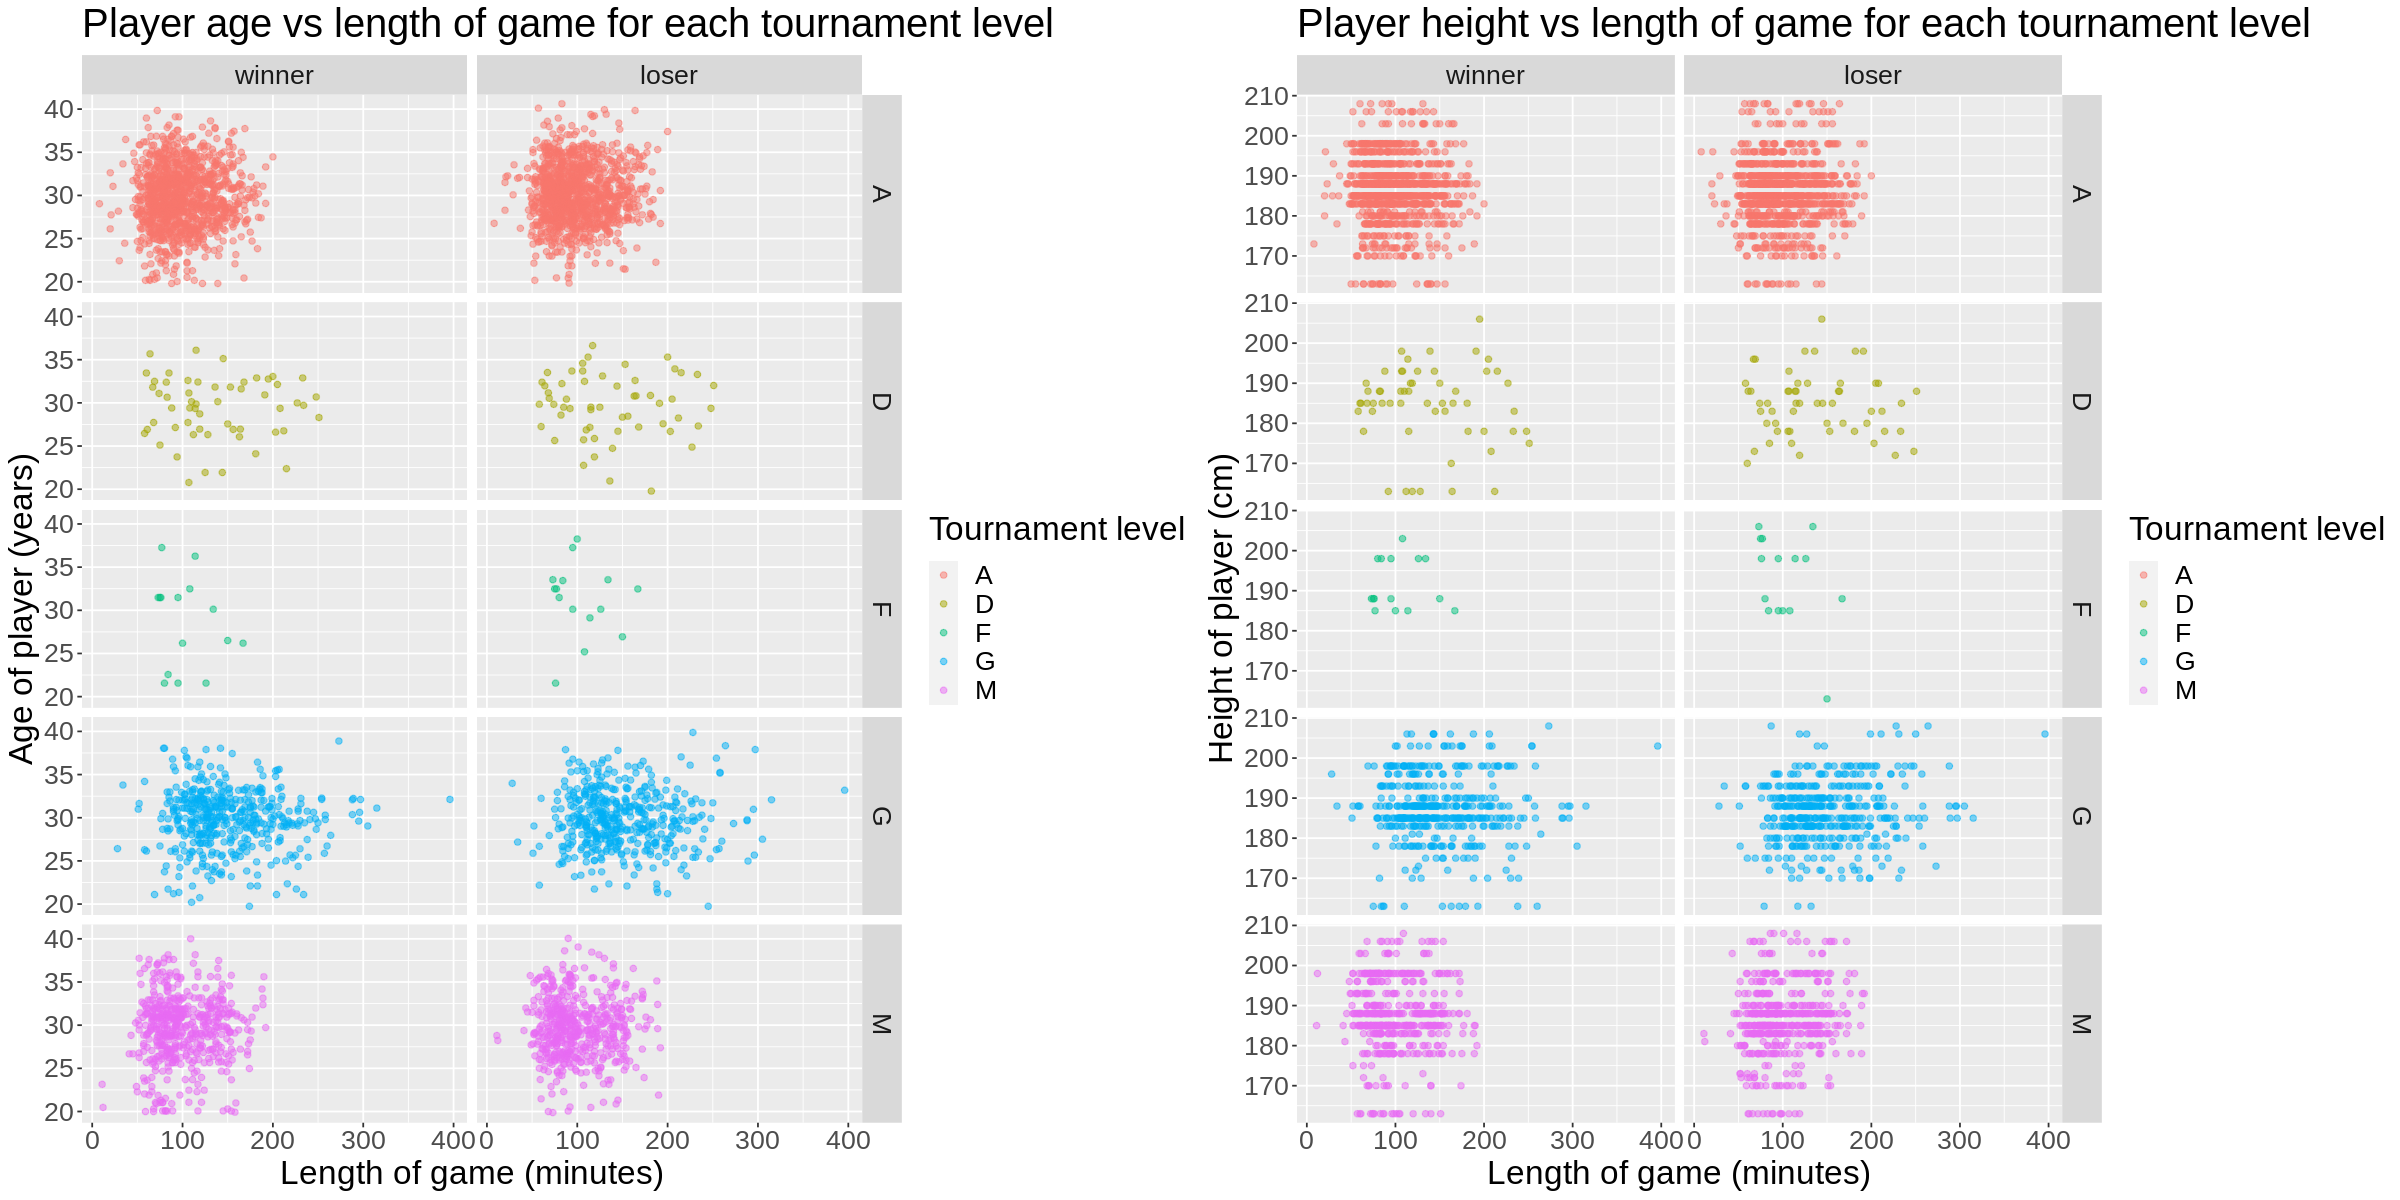

In [9]:
options(repr.plot.width = 20, repr.plot.height = 10)

# Plot the two above plots side by side (saves vertical space)
cowplot::plot_grid(tennis_plot_age, tennis_plot_height)

## Methods
This is a classification problem, therefore we will use the k-nearest neighbors algorithm. To determine the optimal value of k for our model, we will try **10** values of k, cross-validating with 5 folds. This will give us our k to use for our final model.

Since we only care about the variables which physically describe the players we chose the following variables: 
- Tournament level (Being classified)
- Winner and loser height (centimeters)
- Winner and loser age (years)
- Game length (minutes)

We dropped columns in the dataset which were irrelevant to us, such as the players’ name and country. We will also need to drop quite a few rows to ensure that the distribution of levels is roughly equal, which it is not currently as seen in the plot above.

### Visualization

We will visualize the results as follows: 
- accuracy table: since we are mainly concerned as to whether or not we are able to predict the level, we will need to determine if the accuracy of our model is above a certain threshold (better than 60%)
- confusion matrix: this will let us see which levels the model having difficulties predicting, thus allowing us to make targeted improvements. 

## Importance
From looking at the plots, we can see that there are slightly less younger players that lose, and that D and G tournaments have longer matches than other levels. We expect that we will be able to predict tournament levels. However, after looking at the plots, we do not expect that the players’ height will be a very useful predictor in the end.

Since most of which are characteristics of the players, it could signify that there are characteristics more prevalent and/or suited in certain tournaments. For example, we could find that an older and/or taller player is less likely to be in the higher tier tournaments than a younger and/or shorter player. This could give players ideas as to how they’re likely to progress as they age and to what extent they’re limited by their height.

Future questions this could lead to include: 
- What is the optimal age for a tennis player in each level?
- Is there an optimal height for each level?